<a href="https://colab.research.google.com/github/Djebril-senpai/PFE_Project/blob/Junior_branch/PFE_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install sacremoses
#pip install -U transformers
# !pip install wandb

In [ ]:
import wandb
import os

wandb.login()  # tu colles ton API key
os.environ["WANDB_PROJECT"] = "QAmembert_projet"

wandb: Currently logged in as: jeanjunior785 (jeanjunior785-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# 🔹 Fine-tuning Flaubert QA avec LoRA + split + métriques + courbe de loss

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from peft import LoraConfig, get_peft_model


model_name = "CATIE-AQ/QAmembert"        # ou "CATIE-AQ/QAmembert2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        outputs = model.base_model(**inputs, output_hidden_states=True, return_dict=True)
    embedding = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
    return embedding

def test_model_with_metrics(model, tokenizer, questions, contexts, answers, title="Test"):
    sims, ems, f1s = [], [], []

    for q, c, gold in zip(questions, contexts, answers):
        inputs = tokenizer(q, c, return_tensors="pt", truncation=True, max_length=256).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
            start = torch.argmax(outputs.start_logits, dim=1).item()
            end = torch.argmax(outputs.end_logits, dim=1).item()

        pred_tokens = inputs["input_ids"][0][start:end+1]
        pred = tokenizer.decode(pred_tokens, skip_special_tokens=True)

        # Similarity
        emb_pred = get_embedding(pred, model, tokenizer)
        emb_gold = get_embedding(gold, model, tokenizer)
        sim = cosine_similarity(emb_pred, emb_gold)[0][0]

        # EM/F1
        em, f1 = compute_em_f1(pred, gold)

        sims.append(sim)
        ems.append(em)
        f1s.append(f1)

    print(f"\n=== {title} ===")
    print(f"📊 Moyenne CosSim: {np.mean(sims):.4f}")
    print(f"📊 Moyenne EM: {np.mean(ems):.4f}")
    print(f"📊 Moyenne F1: {np.mean(f1s):.4f}")

    return np.mean(sims), np.mean(ems), np.mean(f1s)



def compute_em_f1(pred, gold):
    """
    Calcule Exact Match (EM) et F1 score entre une réponse prédite et la vérité terrain.
    """
    pred_tokens = pred.lower().split()
    gold_tokens = gold.lower().split()

    # Exact Match
    em = int(pred.strip().lower() == gold.strip().lower())

    # F1 Score
    common = set(pred_tokens) & set(gold_tokens)
    if len(common) == 0:
        f1 = 0.0
    else:
        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(gold_tokens)
        f1 = 2 * precision * recall / (precision + recall)

    return em, f1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from datasets import Dataset, DatasetDict
import random

# === 1️⃣ Génération de 60 Q/R de chimie pointue ===
data = [
    # --- Structure moléculaire et liaisons ---
    {"question": "Quel est l’angle de liaison dans une molécule d’eau (H2O) ?",
     "context": "La molécule d’eau est coudée, avec un angle de liaison entre les deux liaisons O-H d’environ 104,5°.",
     "answer": "104,5°"},
    {"question": "Quelle est la géométrie de la molécule de méthane (CH4) ?",
     "context": "Le méthane a une géométrie tétraédrique avec des angles de liaison de 109,5°.",
     "answer": "Tétraédrique"},
    {"question": "Quelle hybridation correspond au carbone dans l’éthylène (C2H4) ?",
     "context": "Dans l’éthylène, chaque carbone est sp2 hybridé.",
     "answer": "sp2"},
    {"question": "Quelle hybridation correspond au carbone dans l’acétylène (C2H2) ?",
     "context": "Dans l’acétylène, chaque carbone est sp hybridé.",
     "answer": "sp"},
    {"question": "Quel type de liaison relie les acides aminés dans une protéine ?",
     "context": "Les acides aminés sont reliés par des liaisons peptidiques (liaisons amides).",
     "answer": "Liaison peptidique"},
    {"question": "Quelle différence entre une liaison covalente polaire et apolaire ?",
     "context": "Une liaison polaire résulte d’une différence d’électronégativité significative, contrairement à une liaison apolaire.",
     "answer": "Différence d’électronégativité"},

    # --- Thermodynamique et cinétique ---
    {"question": "Quelle est la valeur de la constante des gaz parfaits R en J·mol⁻¹·K⁻¹ ?",
     "context": "La constante des gaz parfaits R vaut 8,314 J·mol⁻¹·K⁻¹.",
     "answer": "8,314 J·mol⁻¹·K⁻¹"},
    {"question": "Quelle est la loi qui relie pression, volume et température d’un gaz parfait ?",
     "context": "La loi des gaz parfaits PV = nRT relie pression, volume et température.",
     "answer": "PV = nRT"},
    {"question": "Quelle est la définition de l’enthalpie libre de Gibbs ?",
     "context": "L’enthalpie libre G = H – TS détermine la spontanéité d’une réaction.",
     "answer": "G = H – TS"},
    {"question": "Une réaction est spontanée si ΔG est… ?",
     "context": "Une réaction est spontanée si ΔG < 0.",
     "answer": "ΔG < 0"},
    {"question": "Quelle grandeur détermine la vitesse d’une réaction chimique ?",
     "context": "La vitesse dépend de l’énergie d’activation Ea.",
     "answer": "Énergie d’activation"},
    {"question": "Quel est l’effet d’un catalyseur sur une réaction chimique ?",
     "context": "Un catalyseur abaisse l’énergie d’activation et accélère la réaction sans être consommé.",
     "answer": "Abaisse Ea"},

    # --- Chimie organique ---
    {"question": "Quel est le mécanisme de substitution favorisé en milieu polaire aprotique ?",
     "context": "Les solvants polaires aprotiques favorisent les mécanismes SN2.",
     "answer": "SN2"},
    {"question": "Quel est le mécanisme favorisé en milieu polaire protique ?",
     "context": "Les solvants polaires protiques favorisent les mécanismes SN1.",
     "answer": "SN1"},
    {"question": "Quel test chimique est utilisé pour identifier une double liaison C=C ?",
     "context": "Le test au permanganate de potassium (Baeyer test) détecte les doubles liaisons.",
     "answer": "Test au permanganate"},
    {"question": "Quel type de réaction transforme un alcool en cétone ?",
     "context": "Un alcool secondaire peut être oxydé en cétone.",
     "answer": "Oxydation"},
    {"question": "Quel réactif est utilisé pour bromer sélectivement les alcanes ?",
     "context": "Le brome radicalaire (Br2 sous UV) est utilisé.",
     "answer": "Br2 sous UV"},

    # --- Chimie inorganique ---
    {"question": "Quel est l’état d’oxydation du soufre dans H2SO4 ?",
     "context": "Dans H2SO4, le soufre est à +6.",
     "answer": "+6"},
    {"question": "Quel est l’état d’oxydation du manganèse dans KMnO4 ?",
     "context": "Dans KMnO4, le manganèse est à +7.",
     "answer": "+7"},
    {"question": "Quel est l’ion responsable de l’acidité d’une solution aqueuse ?",
     "context": "L’acidité est due aux ions H+.",
     "answer": "Ion H+"},
    {"question": "Quel est le nom de l’ion SO4²⁻ ?",
     "context": "SO4²⁻ est appelé ion sulfate.",
     "answer": "Sulfate"},
    {"question": "Quel est le nom de l’ion NO3⁻ ?",
     "context": "NO3⁻ est appelé ion nitrate.",
     "answer": "Nitrate"},
    {"question": "Quel est l’ion responsable de la dureté de l’eau ?",
     "context": "Les ions Ca²⁺ et Mg²⁺ provoquent la dureté de l’eau.",
     "answer": "Ca²⁺ et Mg²⁺"},

    # --- Spectroscopie et analytique ---
    {"question": "Quel type de spectroscopie permet d’identifier les groupes fonctionnels ?",
     "context": "La spectroscopie infrarouge (IR) permet d’identifier les vibrations caractéristiques des groupes fonctionnels.",
     "answer": "Spectroscopie IR"},
    {"question": "Quelle spectroscopie donne les déplacements chimiques des protons ?",
     "context": "La RMN du proton (¹H RMN) donne les déplacements chimiques des protons.",
     "answer": "¹H RMN"},
    {"question": "Quel est le principe de la spectroscopie UV-Visible ?",
     "context": "Elle repose sur la transition électronique entre orbitales moléculaires.",
     "answer": "Transitions électroniques"},
    {"question": "Quel est le pic caractéristique du groupe carbonyle en IR ?",
     "context": "Le groupe C=O apparaît vers 1700 cm⁻¹ en IR.",
     "answer": "1700 cm⁻¹"},


    # === Thermodynamique / Thermochimie ===
    {"question": "Quelle est la valeur de la constante des gaz parfaits R ?",
     "context": "R = 8,314 J·mol⁻¹·K⁻¹.",
     "answer": "8,314 J·mol⁻¹·K⁻¹"},
    {"question": "Quelle relation exprime la loi de Hess ?",
     "context": "La loi de Hess stipule que l'enthalpie d'une réaction est la somme des enthalpies des réactions intermédiaires.",
     "answer": "Somme des enthalpies"},
    {"question": "Quel est le signe de ΔH pour une réaction exothermique ?",
     "context": "Une réaction exothermique libère de la chaleur : ΔH < 0.",
     "answer": "ΔH < 0"},
    {"question": "Quelle grandeur détermine la spontanéité d'une réaction chimique ?",
     "context": "La spontanéité est déterminée par l'enthalpie libre ΔG.",
     "answer": "ΔG"},
    {"question": "Quelle équation relie ΔG et la constante d'équilibre K ?",
     "context": "L’équation ΔG = -RT ln K relie ΔG et K.",
     "answer": "ΔG = -RT ln K"},
    {"question": "Quelle loi exprime la relation entre pression de vapeur et température ?",
     "context": "La relation est donnée par l'équation de Clausius-Clapeyron.",
     "answer": "Clausius-Clapeyron"},

    # === Catalyse ===
    {"question": "Quel est le rôle d’un catalyseur dans une réaction chimique ?",
     "context": "Un catalyseur abaisse l’énergie d’activation sans être consommé.",
     "answer": "Abaisse l’énergie d’activation"},
    {"question": "Quel métal est utilisé comme catalyseur dans l’hydrogénation des alcènes ?",
     "context": "Le palladium (Pd), le platine (Pt) ou le nickel (Ni) sont utilisés.",
     "answer": "Pd, Pt ou Ni"},
    {"question": "Quelle enzyme catalyse la conversion du glucose en glucose-6-phosphate ?",
     "context": "La réaction est catalysée par l’hexokinase.",
     "answer": "Hexokinase"},
    {"question": "Qu’appelle-t-on catalyse hétérogène ?",
     "context": "Catalyse où le catalyseur est dans une phase différente des réactifs.",
     "answer": "Catalyseur ≠ phase des réactifs"},
    {"question": "Quel est l’effet de l’inhibition compétitive sur une enzyme ?",
     "context": "L’inhibiteur se fixe sur le site actif et empêche le substrat de se fixer.",
     "answer": "Blocage du site actif"},

    # === Orbitales et chimie quantique ===
    {"question": "Quelle est la configuration électronique du carbone ?",
     "context": "Le carbone (Z=6) : 1s² 2s² 2p².",
     "answer": "1s² 2s² 2p²"},
    {"question": "Quel est le principe d’exclusion de Pauli ?",
     "context": "Deux électrons d’un même atome ne peuvent pas avoir les mêmes quatre nombres quantiques.",
     "answer": "Deux électrons ≠ mêmes 4 nombres quantiques"},
    {"question": "Que signifie HOMO en chimie quantique ?",
     "context": "HOMO signifie Highest Occupied Molecular Orbital.",
     "answer": "Highest Occupied Molecular Orbital"},
    {"question": "Que signifie LUMO en chimie quantique ?",
     "context": "LUMO signifie Lowest Unoccupied Molecular Orbital.",
     "answer": "Lowest Unoccupied Molecular Orbital"},
    {"question": "Que prévoit la théorie VSEPR ?",
     "context": "La théorie VSEPR permet de prédire la géométrie des molécules en minimisant les répulsions électroniques.",
     "answer": "Prédire la géométrie moléculaire"},
    {"question": "Quel est le nombre quantique principal d’un électron 3p ?",
     "context": "Pour un électron 3p, le nombre quantique principal est n=3.",
     "answer": "n=3"},
    {"question": "Quelle est la valeur possible de l pour une orbitale d ?",
     "context": "Pour une orbitale d, le nombre quantique azimutal l=2.",
     "answer": "l=2"},

    # === Biochimie ===
    {"question": "Quelle molécule est la source principale d’énergie cellulaire ?",
     "context": "L’ATP (adénosine triphosphate) est la molécule énergétique universelle.",
     "answer": "ATP"},
    {"question": "Quel type de liaison relie les bases azotées dans l’ADN ?",
     "context": "Les bases azotées sont reliées par des liaisons hydrogène.",
     "answer": "Liaisons hydrogène"},
    {"question": "Quelle est la structure secondaire la plus courante des protéines ?",
     "context": "L’hélice alpha et le feuillet bêta sont les structures secondaires principales.",
     "answer": "Hélice alpha et feuillet bêta"},
    {"question": "Quel cofacteur est nécessaire aux réactions de carboxylation ?",
     "context": "La biotine (vitamine B7) agit comme cofacteur.",
     "answer": "Biotine"},
    {"question": "Quelle enzyme dégrade l’amidon en maltose ?",
     "context": "L’amylase salivaire hydrolyse l’amidon en maltose.",
     "answer": "Amylase"},
    {"question": "Quel est le rôle de la NADH dans la respiration cellulaire ?",
     "context": "Le NADH transporte des électrons vers la chaîne respiratoire mitochondriale.",
     "answer": "Transport d’électrons"},
    {"question": "Quelle molécule est le précurseur du glucose dans la néoglucogenèse ?",
     "context": "Le pyruvate est converti en glucose lors de la néoglucogenèse.",
     "answer": "Pyruvate"},
    {"question": "Quelle enzyme catalyse la réplication de l’ADN ?",
     "context": "La réplication est catalysée par l’ADN polymérase.",
     "answer": "ADN polymérase"},
    {"question": "Quelle est la composition d’un nucléotide ?",
     "context": "Un nucléotide comprend une base azotée, un sucre (pentose) et un phosphate.",
     "answer": "Base + sucre + phosphate"},
    {"question": "Quelle protéine transporte l’oxygène dans le sang ?",
     "context": "L’hémoglobine transporte l’oxygène.",
     "answer": "Hémoglobine"}
]

 # === 2️⃣ Convertir en Dataset HuggingFace ===

# === 2️⃣ Convertir en Dataset HuggingFace ===
dataset = Dataset.from_list(data)
dataset_split = dataset.train_test_split(test_size=0.3, seed=42)
train_dataset = dataset_split["train"]
val_test_split = dataset_split["test"].train_test_split(test_size=0.5, seed=42)
eval_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

chemistry_dataset = DatasetDict({
    "train": train_dataset,
    "validation": eval_dataset,
    "test": test_dataset
})

print("📊 Jeu de données Chimie pointue créé !")
print(f"Train: {len(train_dataset)} | Val: {len(eval_dataset)} | Test: {len(test_dataset)}")
print("Exemple brut :", chemistry_dataset["train"][0])

def preprocess_data(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    start_positions, end_positions = [], []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        input_ids = tokenized["input_ids"][i]
        context = examples["context"][i]
        answer = examples["answer"][i]

        start_char = context.lower().find(answer.lower())
        if start_char == -1:
            # Réponse pas trouvée → ignorer ou forcer sur [CLS]
            start_positions.append(0)
            end_positions.append(0)
            continue
        end_char = start_char + len(answer)

        # séquence des IDs (0=question, 1=context, None=padding)
        sequence_ids = tokenized.sequence_ids(i)

        # indices du segment contexte
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)

        # trouver les tokens correspondant à la réponse
        token_start, token_end = 0, 0
        for j in range(context_start, context_end):
            if offsets[j][0] <= start_char and offsets[j][1] > start_char:
                token_start = j
            if offsets[j][0] < end_char and offsets[j][1] >= end_char:
                token_end = j
                break

        start_positions.append(token_start)
        end_positions.append(token_end)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized


# 🔹 Appliquer correctement la transformation
# Transformation
train_dataset = train_dataset.map(
    preprocess_data,
    batched=True,
    remove_columns=["question", "context", "answer"]
)
eval_dataset = eval_dataset.map(
    preprocess_data,
    batched=True,
    remove_columns=["question", "context", "answer"]
)
test_dataset = test_dataset.map(
    preprocess_data,
    batched=True,
    remove_columns=["question", "context", "answer"]
)


chemistry_dataset = DatasetDict({
    "train": train_dataset,
    "validation": eval_dataset,
    "test": test_dataset
})

# Nettoyage colonnes inutiles
cols_to_remove = ["offset_mapping", "overflow_to_sample_mapping"]
for split in ["train", "validation", "test"]:
    for col in cols_to_remove:
        if col in chemistry_dataset[split].column_names:
            chemistry_dataset[split] = chemistry_dataset[split].remove_columns(col)

# Fixer le format torch
cols = ["input_ids", "attention_mask", "start_positions", "end_positions"]
chemistry_dataset["train"].set_format(type="torch", columns=cols)
chemistry_dataset["validation"].set_format(type="torch", columns=cols)
chemistry_dataset["test"].set_format(type="torch", columns=cols)

📊 Jeu de données Chimie pointue créé !
Train: 38 | Val: 8 | Test: 9
Exemple brut : {'question': 'Quel est le nom de l’ion SO4²⁻ ?', 'context': 'SO4²⁻ est appelé ion sulfate.', 'answer': 'Sulfate'}


Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
# 3️⃣ Charger modèle
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# 4️⃣ Configurer LoRA
print("Configuration LoRA...")
lora_config = LoraConfig(
    r=32,                          # plus petit rang (évite la variance trop forte)
    lora_alpha=16,                # facteur de scaling modéré
    target_modules=["query", "key", "value", "output.dense"],  # uniquement sur attention
    lora_dropout=0.1,             # régularisation
    bias="none"
)
model = get_peft_model(model, lora_config)

def print_trainable_parameters(model):
    trainable = 0
    total = 0
    for _, param in model.named_parameters():
        total += param.numel()
        if param.requires_grad:
            trainable += param.numel()
    print(f"Trainable params: {trainable} / {total} "
          f"({100 * trainable / total:.2f}%)")

# Appeler la fonction
print_trainable_parameters(model)

# 5️⃣ Métriques QA (EM / F1)
import collections
import numpy as np

# === Post-traitement prédictions logits → texte ===
import numpy as np

def make_compute_metrics(eval_ds, tokenizer):
    def compute(p):
        start_logits, end_logits = p.predictions

        n_preds = len(start_logits)
        n_eval  = len(eval_ds)
        n = min(n_preds, n_eval)  # évite IndexError si décalage

        exact_match = 0
        f1_scores = []

        def norm_tokens(s):
            # petit normaliseur simple; ajuste si tu veux enlever accents/ponctuation
            return [t for t in s.lower().strip().split() if t]

        for i in range(n):
            # positions prédites
            start = int(np.argmax(start_logits[i]))
            end   = int(np.argmax(end_logits[i]))
            if end < start:
                end = start  # clamp basique

            # entrée tokenisée
            input_ids = eval_ds[i]["input_ids"]
            if hasattr(input_ids, "tolist"):  # si c’est un tensor numpy/torch
                input_ids = input_ids.tolist()

            gold_start = int(eval_ds[i]["start_positions"])
            gold_end   = int(eval_ds[i]["end_positions"])
            if gold_end < gold_start:
                gold_end = gold_start

            # borne dans la longueur réelle
            L = len(input_ids)
            start = max(0, min(start, L-1))
            end   = max(0, min(end,   L-1))
            gold_start = max(0, min(gold_start, L-1))
            gold_end   = max(0, min(gold_end,   L-1))

            # textes
            pred_text = tokenizer.decode(input_ids[start:end+1], skip_special_tokens=True).strip()
            gold_text = tokenizer.decode(input_ids[gold_start:gold_end+1], skip_special_tokens=True).strip()

            # Exact Match
            exact_match += int(pred_text.lower() == gold_text.lower())

            # F1
            pw, gw = norm_tokens(pred_text), norm_tokens(gold_text)
            if not pw or not gw:
                f1 = 0.0
            else:
                common = len(set(pw) & set(gw))
                precision = common / len(pw)
                recall    = common / len(gw)
                f1 = 2 * precision * recall / (precision + recall) if (precision+recall) > 0 else 0.0
            f1_scores.append(f1)

        return {
            "EM": exact_match / n if n > 0 else 0.0,
            "F1": float(np.mean(f1_scores)) if f1_scores else 0.0,
        }
    return compute







def compute_em_f1(pred, gold):
    """
    Calcule Exact Match (EM) et F1 score entre une réponse prédite et la vérité terrain.
    """
    pred_tokens = pred.lower().split()
    gold_tokens = gold.lower().split()

    # Exact Match
    em = int(pred.strip().lower() == gold.strip().lower())

    # F1 Score
    common = set(pred_tokens) & set(gold_tokens)
    if len(common) == 0:
        f1 = 0.0
    else:
        precision = len(common) / len(pred_tokens)
        recall = len(common) / len(gold_tokens)
        f1 = 2 * precision * recall / (precision + recall)

    return em, f1

Configuration LoRA...
Trainable params: 3833856 / 113866754 (3.37%)


In [ ]:
# 6️⃣ Arguments d'entraînement

training_args = TrainingArguments(
    output_dir="./QAmenbert_projet",
     max_steps=240,
    # num_train_epochs=30,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    logging_steps=20,
    # save_strategy="no",
    remove_unused_columns=False,
    logging_dir="./logs",
    fp16=torch.cuda.is_available(),
    report_to="wandb",
    run_name="QAmembert3"
)

# 7️⃣ Trainer
# Définir l'optimiseur
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.99), eps=1e-8)
# Passer l'optimizer au Trainer

eval_dataset = eval_dataset.remove_columns(["offset_mapping", "overflow_to_sample_mapping"])
train_dataset = train_dataset.remove_columns(["offset_mapping", "overflow_to_sample_mapping"])
test_dataset = test_dataset.remove_columns(["offset_mapping", "overflow_to_sample_mapping"])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
     compute_metrics=make_compute_metrics(eval_dataset, tokenizer),
    optimizers=(optimizer, None)  # None
)

print(len(eval_dataset))               # doit être 8
print(eval_dataset.column_names)


8
['input_ids', 'attention_mask', 'start_positions', 'end_positions']


In [ ]:
print(chemistry_dataset["validation"])
print(eval_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 8
})
Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 8
})


In [ ]:
print(eval_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 8
})


In [ ]:
# 1) Charger SQuAD et choisir un split
piaf = load_dataset("piaf")

# Utiliser directement le split train
subset = piaf["train"].select(range(20))  # 20 exemples pour tester rapidement

general_questions = subset["question"]
general_contexts = subset["context"]
general_answers = [a["text"][0] if len(a["text"]) > 0 else "" for a in subset["answers"]]

print("Nombre d'exemples:", len(general_questions))
print("Exemple Q:", general_questions[0])
print("Exemple Contexte:", general_contexts[0][:120], "…")
print("Exemple Réponse:", general_answers[0])

Nombre d'exemples: 20
Exemple Q: Combien de personnes travaillent au ministère des sports
Exemple Contexte: Les dépenses des ménages représentent plus de 50 % de ces montants (14,2 milliards d'euros en 2003 et 12 milliards d'eur …
Exemple Réponse: 100 000


In [ ]:
# Pour préparer le test set chimie :
chimie_questions = dataset["question"]
chimie_contexts = dataset["context"]
chimie_answers = dataset["answer"]

print("Nombre d'exemples:", len(chimie_questions))
print("Exemple Q:", chimie_questions[0])
print("Exemple Contexte:", chimie_contexts [0][:120], "…")
print("Exemple Réponse:", chimie_answers[0])

Nombre d'exemples: 55
Exemple Q: Quel est l’angle de liaison dans une molécule d’eau (H2O) ?
Exemple Contexte: La molécule d’eau est coudée, avec un angle de liaison entre les deux liaisons O-H d’environ 104,5°. …
Exemple Réponse: 104,5°


In [ ]:
print("\n=== 📊 Évaluation AVANT Fine-tuning ===")
test_model_with_metrics(model, tokenizer, general_questions, general_contexts, general_answers, title="Questions Générales")
test_model_with_metrics(model, tokenizer, chimie_questions, chimie_contexts, chimie_answers, title="Questions Chimie")



=== 📊 Évaluation AVANT Fine-tuning ===

=== Questions Générales ===
📊 Moyenne CosSim: 0.9834
📊 Moyenne EM: 0.6500
📊 Moyenne F1: 0.8567

=== Questions Chimie ===
📊 Moyenne CosSim: 0.8025
📊 Moyenne EM: 0.2909
📊 Moyenne F1: 0.5076


(np.float32(0.8024537),
 np.float64(0.2909090909090909),
 np.float64(0.5075823166732257))

In [ ]:
# 8️⃣ Entraînement
print("Entraînement...")
trainer.train()

Entraînement...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Em,F1
10,No log,1.152096,0.750000,0.625000
20,2.071500,1.114689,0.750000,0.625000
30,2.071500,1.083592,0.750000,0.625000
40,2.310100,1.042983,0.750000,0.625000
50,2.310100,0.999121,0.750000,0.625000
60,2.391000,0.953007,0.750000,0.625000
70,2.391000,0.918061,0.750000,0.625000
80,1.898900,0.857504,0.750000,0.625000
90,1.898900,0.804967,0.750000,0.625000
100,1.969800,0.762783,0.750000,0.625000


TrainOutput(global_step=240, training_loss=1.8462900956471762, metrics={'train_runtime': 2443.1617, 'train_samples_per_second': 0.196, 'train_steps_per_second': 0.098, 'total_flos': 98306770452480.0, 'train_loss': 1.8462900956471762, 'epoch': 12.631578947368421})

In [ ]:
print("\n=== 📊 Évaluation APRES Fine-tuning ===")
test_model_with_metrics(model, tokenizer, general_questions, general_contexts, general_answers, title="Questions Générales")
test_model_with_metrics(model, tokenizer, chimie_questions, chimie_contexts, chimie_answers, title="Questions Chimie")



=== 📊 Évaluation APRES Fine-tuning ===

=== Questions Générales ===
📊 Moyenne CosSim: 0.9816
📊 Moyenne EM: 0.6500
📊 Moyenne F1: 0.8567

=== Questions Chimie ===
📊 Moyenne CosSim: 0.6513
📊 Moyenne EM: 0.2727
📊 Moyenne F1: 0.4485


(np.float32(0.6513114),
 np.float64(0.2727272727272727),
 np.float64(0.4484769775678867))

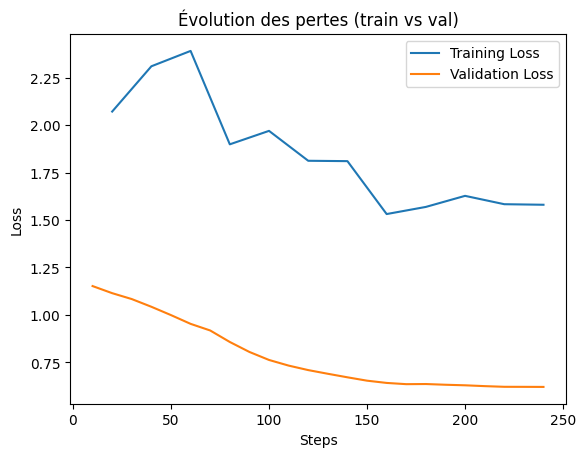

In [ ]:

# 9️⃣ Courbe de training + validation loss
logs = trainer.state.log_history

train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
steps = [log["step"] for log in logs if "loss" in log]

plt.plot(steps, train_loss, label="Training Loss")
if eval_loss:  # sécurité si pas de val
    eval_steps = [log["step"] for log in logs if "eval_loss" in log]
    plt.plot(eval_steps, eval_loss, label="Validation Loss")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Évolution des pertes (train vs val)")
plt.legend()
plt.show()


In [ ]:

# # 🔹 Test QA direct
# print("\nTest QA rapide après fine-tuning")
# question = "Quel est le bénéfice net de la société ?"
# context = "La société a réalisé un bénéfice net de 5 millions d'euros en 2023."
# inputs = tokenizer(question, context, return_tensors="pt")
# outputs = model(**inputs)
# start_idx = outputs.start_logits.argmax()
# end_idx = outputs.end_logits.argmax()
# answer_tokens = inputs.input_ids[0][start_idx:end_idx+1]
# answer = tokenizer.decode(answer_tokens)

# print(f"Question: {question}")
# print(f"Réponse: {answer}")

**Test  post-fine-tuning ADIL Data Sport**

In [ ]:
data2 = [
    {"question": "Qui a marqué un doublé en Ligue des Champions ?", "context": "Kylian Mbappé a marqué un doublé en Ligue des Champions.", "answer": "Kylian Mbappé"},
    {"question": "Quel joueur a été transféré à Manchester City ?", "context": "Erling Haaland a été transféré à Manchester City pour renforcer l'effectif.", "answer": "Erling Haaland"},
    {"question": "Quel club a remporté la Coupe du Monde ?", "context": "L'équipe de France a remporté la Coupe du Monde en battant la Croatie en finale.", "answer": "équipe de France"},
    {"question": "Qui a été élu homme du match ?", "context": "Lionel Messi a été élu homme du match après une performance exceptionnelle.", "answer": "Lionel Messi"},
    {"question": "Qui a prolongé son contrat avec PSG ?", "context": "Kylian Mbappé a prolongé son contrat avec PSG jusqu'en 2026.", "answer": "Kylian Mbappé"},
    {"question": "Qui a été blessé lors du dernier match de Real Madrid ?", "context": "Karim Benzema a été blessé lors du dernier match de Real Madrid.", "answer": "Karim Benzema"},
    {"question": "Qui a délivré une passe décisive contre FC Barcelone ?", "context": "Kevin De Bruyne a délivré une passe décisive contre FC Barcelone.", "answer": "Kevin De Bruyne"},
    {"question": "Qui a remporté le titre de meilleur buteur en Premier League ?", "context": "Erling Haaland a remporté le titre de meilleur buteur en Premier League.", "answer": "Erling Haaland"},
    {"question": "Quel joueur a été transféré à Liverpool ?", "context": "Mohamed Salah a été transféré à Liverpool pour renforcer l'effectif.", "answer": "Mohamed Salah"},
    {"question": "Quel club a remporté la Ligue des Champions ?", "context": "Real Madrid a remporté la Ligue des Champions en battant Manchester City en finale.", "answer": "Real Madrid"},
    {"question": "Qui a marqué un doublé en Copa America ?", "context": "Lionel Messi a marqué un doublé en Copa America.", "answer": "Lionel Messi"},
    {"question": "Qui a été élu homme du match ?", "context": "Cristiano Ronaldo a été élu homme du match après une performance exceptionnelle.", "answer": "Cristiano Ronaldo"},
    {"question": "Qui a prolongé son contrat avec Manchester City ?", "context": "Kevin De Bruyne a prolongé son contrat avec Manchester City jusqu'en 2026.", "answer": "Kevin De Bruyne"},
    {"question": "Qui a délivré une passe décisive contre Bayern Munich ?", "context": "Neymar a délivré une passe décisive contre Bayern Munich.", "answer": "Neymar"},
    {"question": "Quel club a remporté la Serie A ?", "context": "Napoli a remporté la Serie A en dominant toute la saison.", "answer": "Napoli"},
    {"question": "Qui a été blessé lors du dernier match de PSG ?", "context": "Neymar a été blessé lors du dernier match de PSG.", "answer": "Neymar"},
    {"question": "Qui a remporté le titre de meilleur buteur en Ligue des Champions ?", "context": "Karim Benzema a remporté le titre de meilleur buteur en Ligue des Champions.", "answer": "Karim Benzema"},
    {"question": "Quel joueur a été transféré à Chelsea ?", "context": "João Félix a été transféré à Chelsea pour renforcer l'effectif.", "answer": "João Félix"},
    {"question": "Qui a été élu homme du match ?", "context": "Erling Haaland a été élu homme du match après une performance exceptionnelle.", "answer": "Erling Haaland"},
    {"question": "Qui a marqué un doublé en Bundesliga ?", "context": "Harry Kane a marqué un doublé en Bundesliga.", "answer": "Harry Kane"},
    {"question": "Quel club a remporté la Copa America ?", "context": "L'Argentine a remporté la Copa America en battant le Brésil en finale.", "answer": "Argentine"},
    {"question": "Qui a prolongé son contrat avec Liverpool ?", "context": "Mohamed Salah a prolongé son contrat avec Liverpool jusqu'en 2026.", "answer": "Mohamed Salah"},
    {"question": "Qui a délivré une passe décisive contre Real Madrid ?", "context": "Kylian Mbappé a délivré une passe décisive contre Real Madrid.", "answer": "Kylian Mbappé"},
    {"question": "Quel joueur a été transféré à Juventus ?", "context": "Angel Di Maria a été transféré à Juventus pour renforcer l'effectif.", "answer": "Angel Di Maria"},
    {"question": "Qui a été blessé lors du dernier match de Bayern Munich ?", "context": "Sadio Mané a été blessé lors du dernier match de Bayern Munich.", "answer": "Sadio Mané"},
    {"question": "Qui a remporté le titre de meilleur buteur en Euro ?", "context": "Cristiano Ronaldo a remporté le titre de meilleur buteur en Euro.", "answer": "Cristiano Ronaldo"},
    {"question": "Quel club a remporté la Coupe de France ?", "context": "PSG a remporté la Coupe de France en battant Marseille en finale.", "answer": "PSG"},
    {"question": "Qui a marqué un doublé en Liga ?", "context": "Robert Lewandowski a marqué un doublé en Liga.", "answer": "Robert Lewandowski"},
    {"question": "Qui a été élu homme du match ?", "context": "Jude Bellingham a été élu homme du match après une performance exceptionnelle.", "answer": "Jude Bellingham"},
    {"question": "Quel joueur a été transféré à Arsenal ?", "context": "Gabriel Jesus a été transféré à Arsenal pour renforcer l'effectif.", "answer": "Gabriel Jesus"},
    {"question": "Qui a prolongé son contrat avec FC Barcelone ?", "context": "Pedri a prolongé son contrat avec FC Barcelone jusqu'en 2028.", "answer": "Pedri"},
    {"question": "Qui a été blessé lors du dernier match de Manchester United ?", "context": "Marcus Rashford a été blessé lors du dernier match de Manchester United.", "answer": "Marcus Rashford"},
    {"question": "Qui a délivré une passe décisive contre Chelsea ?", "context": "Luka Modric a délivré une passe décisive contre Chelsea.", "answer": "Luka Modric"},
    {"question": "Quel club a remporté l'Europa League ?", "context": "Sevilla a remporté l'Europa League pour la 7e fois de son histoire.", "answer": "Sevilla"},
    {"question": "Qui a remporté le titre de meilleur buteur en Bundesliga ?", "context": "Robert Lewandowski a remporté le titre de meilleur buteur en Bundesliga.", "answer": "Robert Lewandowski"},
    {"question": "Qui a été élu homme du match ?", "context": "Antoine Griezmann a été élu homme du match après une performance exceptionnelle.", "answer": "Antoine Griezmann"},
    {"question": "Qui a marqué un doublé en Euro ?", "context": "Antoine Griezmann a marqué un doublé en Euro.", "answer": "Antoine Griezmann"},
    {"question": "Quel joueur a été transféré à Tottenham ?", "context": "Richarlison a été transféré à Tottenham pour renforcer l'effectif.", "answer": "Richarlison"},
    {"question": "Qui a prolongé son contrat avec Real Madrid ?", "context": "Luka Modric a prolongé son contrat avec Real Madrid jusqu'en 2025.", "answer": "Luka Modric"},
    {"question": "Qui a été blessé lors du dernier match de FC Barcelone ?", "context": "Gavi a été blessé lors du dernier match de FC Barcelone.", "answer": "Gavi"}
]


In [ ]:
data2 = Dataset.from_list(data2)

In [ ]:
# Pour préparer le test set chimie :
sport_questions = data2["question"]
sport_contexts = data2["context"]
sport_answers = data2["answer"]

print("Nombre d'exemples:", len(sport_questions))
print("Exemple Q:", sport_questions[0])
print("Exemple Contexte:", sport_contexts[0][:120], "…")
print("Exemple Réponse:", sport_answers[0])

Nombre d'exemples: 40
Exemple Q: Qui a marqué un doublé en Ligue des Champions ?
Exemple Contexte: Kylian Mbappé a marqué un doublé en Ligue des Champions. …
Exemple Réponse: Kylian Mbappé


In [ ]:
print("\n=== 📊 Évaluation APRES Fine-tuning ===")
print("\n=== 📊 Évaluation APRES Fine-tuning (sport adil) ===")
test_model_with_metrics(model, tokenizer, general_questions, general_contexts, general_answers, title="Questions Générales")
test_model_with_metrics(model, tokenizer, sport_questions, sport_contexts, sport_answers, title="Questions Sport")


=== 📊 Évaluation APRES Fine-tuning ===

=== 📊 Évaluation APRES Fine-tuning (sport adil) ===

=== Questions Générales ===
📊 Moyenne CosSim: 0.9816
📊 Moyenne EM: 0.6500
📊 Moyenne F1: 0.8567

=== Questions Sport ===
📊 Moyenne CosSim: 0.9980
📊 Moyenne EM: 0.9500
📊 Moyenne F1: 0.9792


(np.float32(0.9980253), np.float64(0.95), np.float64(0.9791666666666666))